In [1]:
import logging
import h5py
from keras.layers import Convolution2D, MaxPooling2D  # Layer Def
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.utils.io_utils import HDF5Matrix
import h5py
import pandas
import numpy as np
from collections import defaultdict
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
def colorTable(index=0):
    color_tab = [(31, 119, 180), (174, 199, 232), (255, 127, 14),
                 (255, 187, 120), (44, 160, 44), (152, 223, 138),
                 (214, 39, 40), (255, 152, 150), (148, 103, 189),
                 (197, 176, 213), (140, 86, 75), (196, 156, 148),
                 (227, 119, 194), (247, 182, 210), (127, 127, 127),
                 (199, 199, 199), (188, 189, 34), (219, 219, 141),
                 (23, 190, 207), (158, 218, 229)]
    r = float(color_tab[index][0])/255.0
    g = float(color_tab[index][1])/255.0
    b = float(color_tab[index][2])/255.0
    return (r, g, b)

Using TensorFlow backend.


In [2]:
class B2DataGenerator(object):
    batch_size = 100
    logger = logging.getLogger("b2.data")
    def __init__(self, datapath, dataset, input_data_desc, output_data_desc):
        self.logger.info("Assembling DataSet")
        self._file = h5py.File(datapath,'r')
        self._dataset = self._file[dataset]
        
        self._data_desc=input_data_desc
        self.output_data_desc = output_data_desc
        
        #book keeping
        self.current_index=0

        # This is put here
        self.indices=[]
        self.prediction_index = -1
        for row in self._data_desc:
            for col in row:
                for key in self._dataset.attrs:
                    if self._dataset.attrs[key] == col:
                        self.indices.append(int(key.split('x')[1].split('_')[0]))
                    elif self._dataset.attrs[key] == self.output_data_desc[0]:
                        self.prediction_index = int(key.split('x')[1].split('_')[0])        
        
    def output(self):
        """
            Returns an input layer with the appropriate shape to
            match the data that we're using.
        """
        return Input(shape=(len(self._data_desc),len(self._data_desc[0]),1))

    def __len__(self):
        """
        This assumes all of the data is stored in rows
        """
        return self._dataset.shape[0]

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        """
            Fetches out the next batch of data frames
            
            Note that there's a fun error here where if you over-optimize this
            function, it initiates a race condition on the CPU. Ask kwierman to submit 
            a ticket to fchollett.
        """
        batch = self._dataset[self.current_index:self.current_index+self.batch_size]
        data = batch[:, tuple(self.indices)]
        data = data.reshape( (self.batch_size,len(self._data_desc),len(self._data_desc[0]),1) )
        prediction = np.zeros(shape=(len(batch[:, self.prediction_index]),1))
        prediction[:,0] = batch[:, self.prediction_index]
        self.current_index+=self.batch_size
        return (data, prediction)

In [3]:
input_data_desc=[
    ['B0_R2','B0_CosTBTO'],
    ['B0_KST0_pi__piid','B0_KST0_K__piid'],
    ['B0_KST0_K_P','B0_KST0_pi_P'],
    ['nTracks','B0_gamma_clusterE9E25'],
    ['nGoodNeutralECLClusters','B0_gamma_CosTBTO'],
    ['B0_KST0_K_d0','B0_KST0_K_z0'],
    ['B0_KST0_pi_d0','B0_KST0_pi_z0'],
]

output_data_desc=['B0__isSignal']
BtoKstG_datagen = B2DataGenerator('chargedrec_mc7_phaseII_BGx1_KstZG.h5','BtoKstG',input_data_desc, output_data_desc)

## Load up a model with trained weights

Using the `trained_weights.h5` file from the previous exercise, load up a model.

In [4]:
class VGG16(Model):
    logger = logging.getLogger('b2.vgg16')
    def __init__(self, input_data,loss='binary_crossentropy'):
        self._input = input_data
        self.logger.info("Assembling Model")

        self.logger.debug("Input Shape: {}".format(self._input))

        # Block 1
        layer = Convolution2D(64, 2, 2, activation='relu', border_mode='same', 
                              name='block1_conv1')(self._input)
        layer = Convolution2D(64, 2, 2, activation='relu', border_mode='same', 
                              name='block1_conv2')(layer)
        layer = MaxPooling2D((2, 1), strides=(1, 1), name='block1_pool')(layer)

        # Block 2
        layer = Convolution2D(128, 2, 1, activation='relu', border_mode='same', 
                              name='block2_conv1')(layer)
        layer = Convolution2D(128, 1, 2, activation='relu', border_mode='same', 
                              name='block2_conv2')(layer)
        layer = MaxPooling2D((2, 1), strides=(1, 1), name='block2_pool')(layer)


        # Classification block
        layer = Flatten(name='flatten')(layer)
        layer = Dense(256, activation='relu', name='fc1')(layer)
        layer = Dense(256, activation='relu', name='fc2')(layer)
        layer = Dense(2, activation='softmax', name='predictions')(layer)

        super(VGG16, self).__init__(self._input, layer)
        self.logger.info("Compiling Model")
        self.compile(loss=loss, optimizer='sgd')

In [5]:
logging.basicConfig(level=logging.DEBUG)
logging.info("Starting...")

model = VGG16(BtoKstG_datagen.output(), loss="sparse_categorical_crossentropy")
model.load_weights('trained_weights.h5')

INFO:root:Starting...
INFO:b2.vgg16:Assembling Model
DEBUG:b2.vgg16:Input Shape: Tensor("input_1:0", shape=(?, 7, 2, 1), dtype=float32)
INFO:b2.vgg16:Compiling Model


# Running Analysis on the network output

In [6]:
data, truths = BtoKstG_datagen.next()
predictions = model.predict(data)

In [7]:
print "Truth: ",truths[:,0]
print "Prediction: ", predictions[:,0]

Truth:  [ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]
Prediction:  [ 0.1134936   0.74668163  0.9823736   0.99747318  0.99984729  0.97132695
  0.68279457  0.0539356   0.99944347  0.93945026  0.90157074  0.03387149
  0.99903595  0.99713755  0.02373062  0.98607451  0.99700004  0.027983
  0.98565185  0.96487278  0.99116546  0.99819475  0.24422488  0.81786561
  0.06478981  0.99972874  0.04010942  0.99955159  0.99401891  0.76946408
  0.93580347  0.74124819  0.15115638  0.99881774  0.95285481  0.99503928
  0.9634434   0.99844474  0.99933654  0.99553865  0.03654848  0.99975997
  0.92465019  0.94758242  0.04167048  0.84083682  0.72340459  0

In [8]:
def get_accuracy_for_batch(truths, predictions, softmax_threshold=0.3):
    assert( len(predictions[:,0]) == len(truths[:,0]) )
    n_correct = 0
    for index, value in enumerate(predictions[:,0]):
        if value <=softmax_threshold and truths[index,0]:
            n_correct+=1
        elif value> softmax_threshold and not truths[index,0]:
            n_correct+=1
    return float(n_correct)/len(predictions[:,0])
            

In [9]:
get_accuracy_for_batch(truths, predictions, 0.3)

0.97

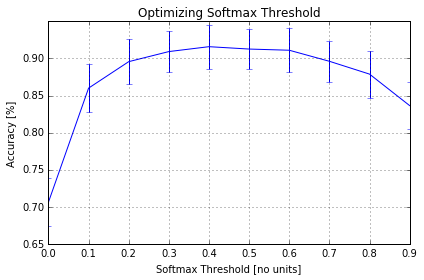

In [10]:
plt.figure()
X = [i*0.1 for i in range(10)]
Y=[]
Y_Err=[]
for x in X:
    batch_accuracies=[]
    for i in range(100):
        data, truths = BtoKstG_datagen.next()
        predictions = model.predict(data)
        batch_accuracies.append(get_accuracy_for_batch(truths, predictions, x))
    Y.append(np.average(batch_accuracies))
    Y_Err.append(np.std(batch_accuracies))
plt.errorbar(X,Y, yerr=Y_Err)
plt.title("Optimizing Softmax Threshold")
plt.xlabel("Softmax Threshold [no units]")
plt.ylabel("Accuracy [%]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Generating an Inference Data Set

In [11]:
with open('inference_output.csv','w') as output:
    header="batch,"
    for i in range(7):
        for j in range(2):
            header+="{},".format(input_data_desc[i][j])
    header+="truth,prediction\n"
    output.write(header)
    for batch in range(1000):
        data, truths = BtoKstG_datagen.next()
        predictions = model.predict(data)
        for frame in zip(data, truths, predictions):
            line="{},".format(batch)
            for i in range(7):
                for j in range(2):
                    line+="{},".format(frame[0][i][j][0])
            line+="{},{}\n".format(frame[1][0], frame[2][0])
            output.write(line)

# Analyzing the Data Set


In [24]:
df = pandas.read_csv('inference_output.csv')

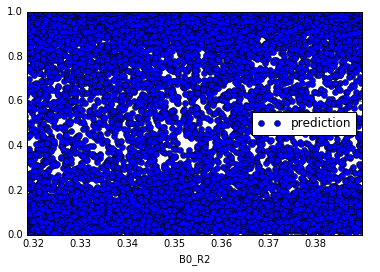

In [25]:
df.plot(x='B0_R2', y='prediction', style='o')

B0_R2 100000
B0_CosTBTO 100000
B0_KST0_pi__piid 100000
B0_KST0_K__piid 100000
B0_KST0_K_P 100000
B0_KST0_pi_P 100000
nTracks 100000
B0_gamma_clusterE9E25 100000
nGoodNeutralECLClusters 100000
B0_gamma_CosTBTO 100000
B0_KST0_K_d0 100000
B0_KST0_K_z0 100000
B0_KST0_pi_d0 100000
B0_KST0_pi_z0 100000


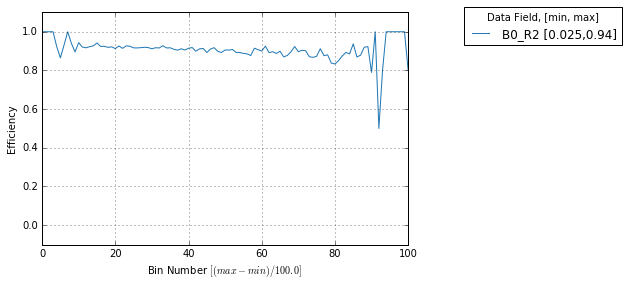

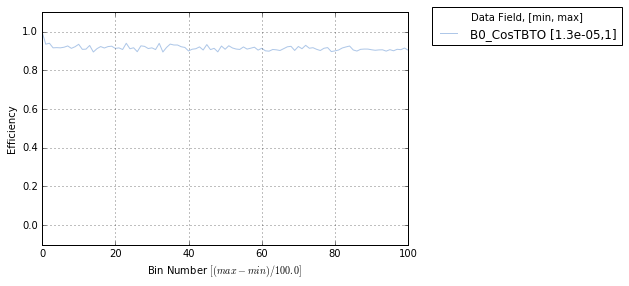

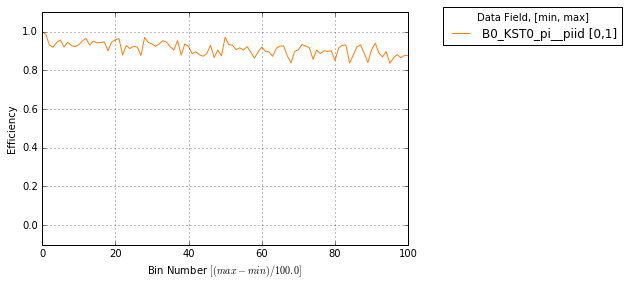

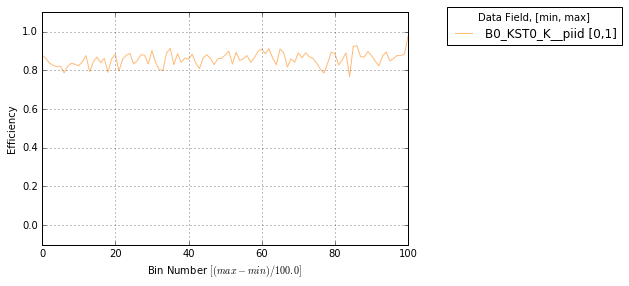

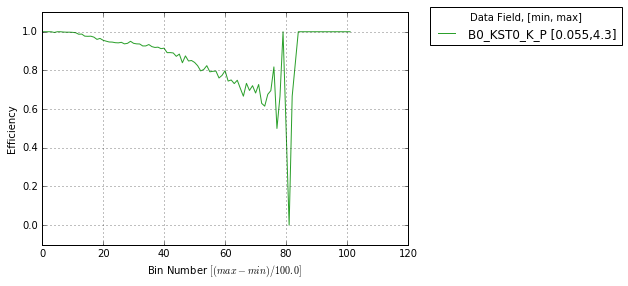

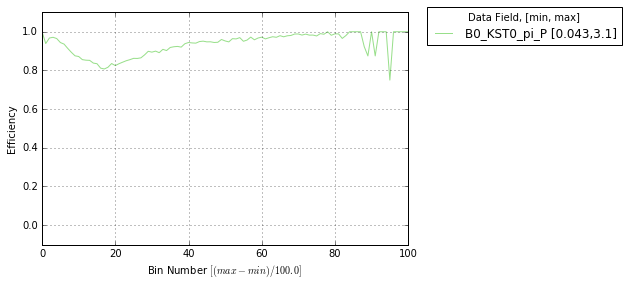

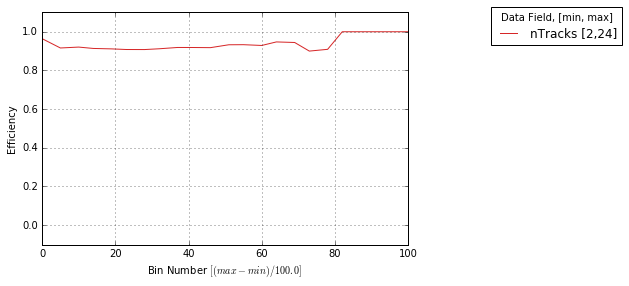

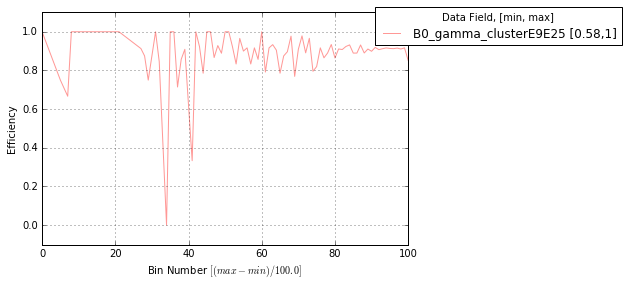

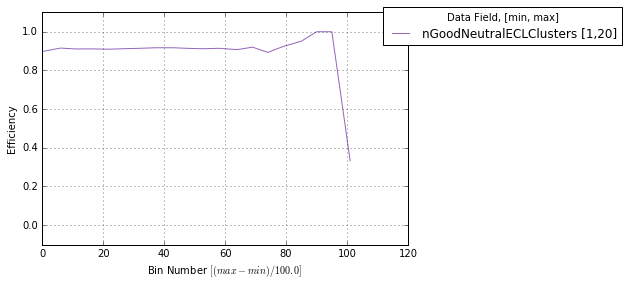

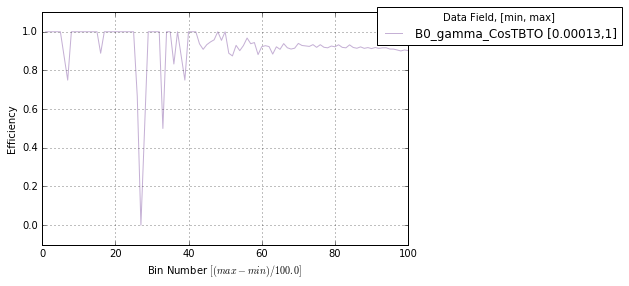

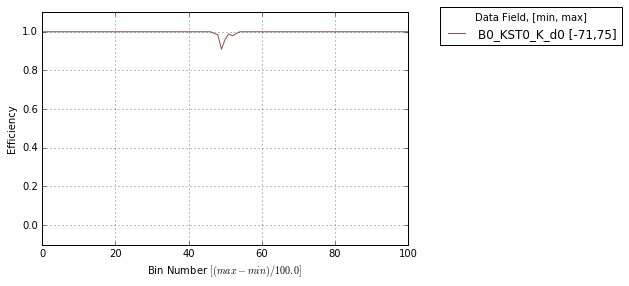

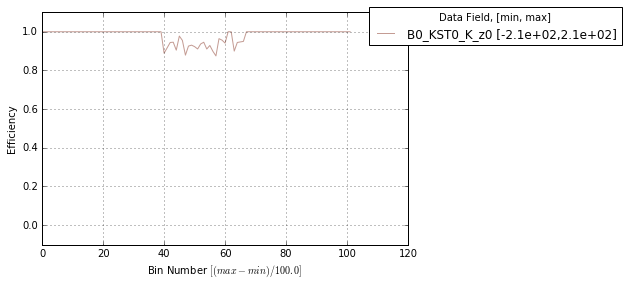

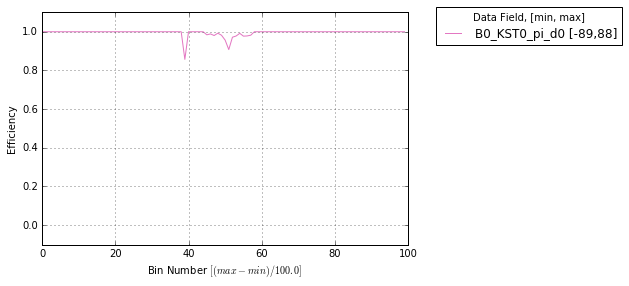

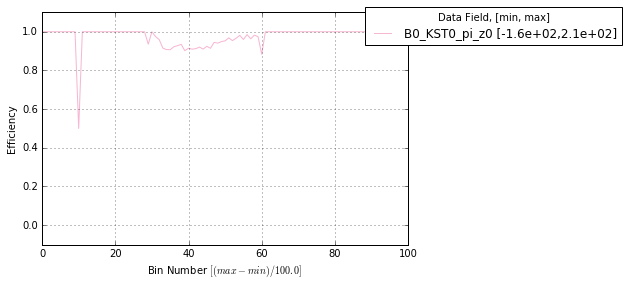

In [56]:

table_index=0
for primary_index in range(7):
    for secondary_index in range(2):
        data_label =input_data_desc[primary_index][secondary_index]
        print data_label, len(df[data_label])
        n_bins=float(100)
        step_size = (np.max(df[data_label])-np.min(df[data_label]))/n_bins
        bins = np.arange(np.min(df[data_label])-step_size, np.max(df[data_label])+step_size, step_size)
        centers = [ i + (step_size/2.0) for i in bins[:-1]]
        df['{}_bin'.format(data_label)] = pandas.cut(df[data_label],bins,labels=centers)
        X=[]
        Y=[]
        for index, label in enumerate(centers):
            binned_values = df.loc[ df['{}_bin'.format(data_label)]  == label]
            if len(binned_values)>0:
                correct_true = binned_values.loc[binned_values.prediction<=0.5].loc[binned_values.truth == 1]
                correct_false = binned_values.loc[binned_values.prediction>0.5].loc[binned_values.truth == 0]
                accuracy = (len(correct_false) + len(correct_true))/float(len(binned_values))
                X.append(index)
                Y.append(accuracy)
            else:
                continue
        if len(Y)>0:
            plt.figure()
            plt.plot(X,Y, label=data_label+" [{:.2g},{:.2g}]".format(np.min(df[data_label]),
                                                                     np.max(df[data_label])),
                     color=colorTable(table_index))
            table_index+=1
            plt.grid()
            plt.ylim(-0.1,1.1)
            plt.legend(bbox_to_anchor=(1.6, 1.05), title="Data Field, [min, max]")
            plt.xlabel("Bin Number $[(max-min) /{}]$".format(n_bins))
            plt.ylabel("Efficiency")
            plt.tight_layout()
plt.show()